In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import f_oneway, ttest_ind
from itertools import combinations
import warnings
warnings.filterwarnings('ignore')

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

In [2]:
print("Loading mHealth dataset from all subjects...\n")

column_names = ['chest_acc_x', 'chest_acc_y', 'chest_acc_z', 'ecg_lead1', 'ecg_lead2',
                'ankle_acc_x', 'ankle_acc_y', 'ankle_acc_z', 'ankle_gyro_x', 'ankle_gyro_y', 
                'ankle_gyro_z', 'ankle_mag_x', 'ankle_mag_y', 'ankle_mag_z', 'arm_acc_x', 
                'arm_acc_y', 'arm_acc_z', 'arm_gyro_x', 'arm_gyro_y', 'arm_gyro_z',
                'arm_mag_x', 'arm_mag_y', 'arm_mag_z', 'activity_label']

activity_map = {0: 'Null', 1: 'Standing still', 2: 'Sitting and relaxing', 3: 'Lying down',
                4: 'Walking', 5: 'Climbing stairs', 6: 'Waist bends forward', 
                7: 'Frontal elevation of arms', 8: 'Knees bending', 9: 'Cycling', 
                10: 'Jogging', 11: 'Running', 12: 'Jump front & back'}

all_data = []
for i in range(1, 11):
    try:
        df = pd.read_csv(f'mHealth_subject{i}.log', sep='\t', header=None, names=column_names)
        df['subject_id'] = i
        all_data.append(df)
        print(f"Loaded subject {i}: {len(df):,} samples")
    except FileNotFoundError:
        print(f"Subject {i} file not found")

data = pd.concat(all_data, ignore_index=True)
print(f"\nTotal: {len(data):,} samples from {data['subject_id'].nunique()} subjects")

Loading mHealth dataset from all subjects...

Loaded subject 1: 161,280 samples
Loaded subject 2: 130,561 samples
Loaded subject 3: 122,112 samples
Loaded subject 4: 116,736 samples
Loaded subject 5: 119,808 samples
Loaded subject 6: 98,304 samples
Loaded subject 7: 104,448 samples
Loaded subject 8: 129,024 samples
Loaded subject 9: 135,168 samples
Loaded subject 10: 98,304 samples

Total: 1,215,745 samples from 10 subjects


In [3]:
print("\n\nData Cleaning:\n")

# Handle missing values
sensor_cols = [col for col in data.columns if col not in ['activity_label', 'subject_id']]
data[sensor_cols] = data[sensor_cols].fillna(method='ffill').fillna(method='bfill')
print(f"Missing values handled: {data.isnull().sum().sum()} remaining")

# Remove null class
data_clean = data[data['activity_label'] != 0].copy()
print(f"Null class removed: {len(data_clean):,} samples remain")

# Remove outliers
def remove_outliers(df, cols, threshold=3):
    for col in cols:
        Q1, Q3 = df[col].quantile([0.25, 0.75])
        IQR = Q3 - Q1
        df = df[(df[col] >= Q1-threshold*IQR) & (df[col] <= Q3+threshold*IQR)]
    return df

numeric_cols = ['chest_acc_x', 'chest_acc_y', 'chest_acc_z', 'ankle_acc_x', 
                'ankle_acc_y', 'ankle_acc_z', 'arm_acc_x', 'arm_acc_y', 'arm_acc_z']
data_clean = remove_outliers(data_clean, numeric_cols)
print(f"Outliers removed: {len(data_clean):,} samples ({len(data_clean)/len(data)*100:.1f}% retained)")



Data Cleaning:

Missing values handled: 0 remaining
Null class removed: 343,195 samples remain
Outliers removed: 245,819 samples (20.2% retained)


In [4]:
print("\n\nFeature Engineering:\n")

data_clean['chest_acc_magnitude'] = np.sqrt(data_clean[['chest_acc_x', 'chest_acc_y', 'chest_acc_z']].pow(2).sum(axis=1))
data_clean['ankle_acc_magnitude'] = np.sqrt(data_clean[['ankle_acc_x', 'ankle_acc_y', 'ankle_acc_z']].pow(2).sum(axis=1))
data_clean['arm_acc_magnitude'] = np.sqrt(data_clean[['arm_acc_x', 'arm_acc_y', 'arm_acc_z']].pow(2).sum(axis=1))
data_clean['heart_rate_estimate'] = data_clean.groupby(['subject_id', 'activity_label'])['ecg_lead1'].transform(lambda x: 70 + x.std()*30)
data_clean['activity_name'] = data_clean['activity_label'].map(activity_map)

print("Created: chest/ankle/arm acceleration magnitudes, heart rate estimate, activity names")



Feature Engineering:

Created: chest/ankle/arm acceleration magnitudes, heart rate estimate, activity names




Activity Distribution:

activity_name
Standing still               30720
Sitting and relaxing         30720
Cycling                      30657
Climbing stairs              29487
Knees bending                29106
Waist bends forward          27143
Frontal elevation of arms    27004
Walking                      23934
Jogging                       7685
Jump front & back             3458
Lying down                    3072
Running                       2833
Name: count, dtype: int64


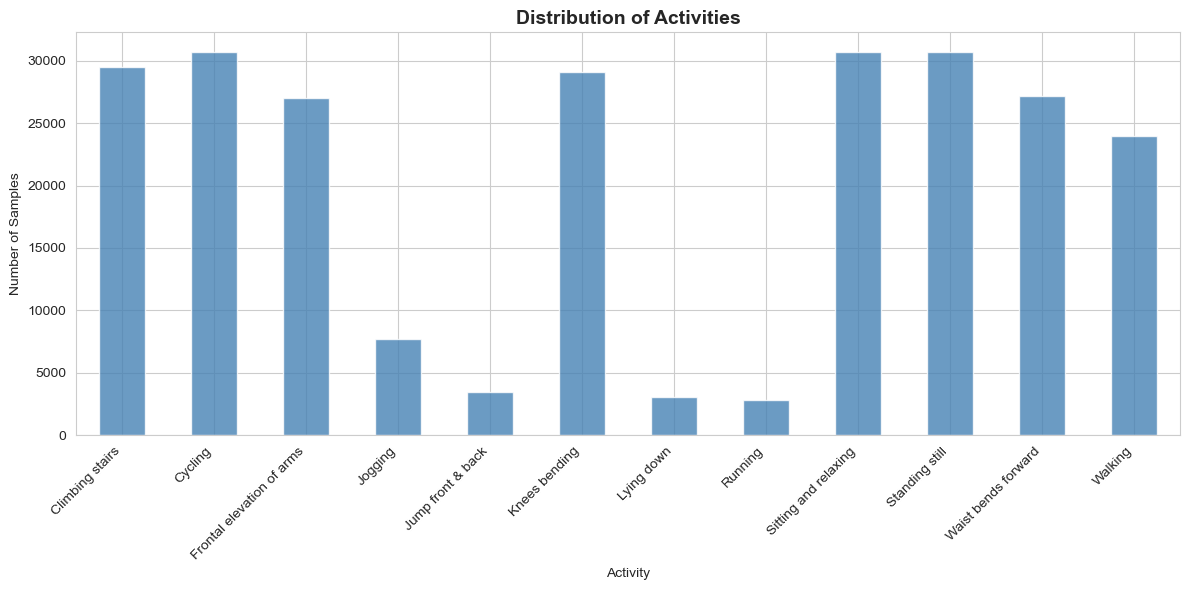

In [5]:
print("\n\nActivity Distribution:\n")
print(data_clean['activity_name'].value_counts())

plt.figure(figsize=(12, 6))
data_clean['activity_name'].value_counts().sort_index().plot(kind='bar', color='steelblue', alpha=0.8)
plt.title('Distribution of Activities', fontsize=14, fontweight='bold')
plt.xlabel('Activity')
plt.ylabel('Number of Samples')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [6]:
print("\n\nDescriptive Statistics by Activity:\n")

summary = data_clean.groupby('activity_name').agg({
    'chest_acc_magnitude': ['count', 'mean', 'std'],
    'ankle_acc_magnitude': ['mean', 'std'],
    'heart_rate_estimate': ['mean', 'std']
}).round(3)
print(summary)

summary.to_csv('activity_summary_statistics.csv')
print("\nSaved to: activity_summary_statistics.csv")



Descriptive Statistics by Activity:

                          chest_acc_magnitude                \
                                        count   mean    std   
activity_name                                                 
Climbing stairs                         29487  9.778  2.099   
Cycling                                 30657  9.600  1.257   
Frontal elevation of arms               27004  9.798  0.327   
Jogging                                  7685  8.305  6.942   
Jump front & back                        3458  5.259  6.055   
Knees bending                           29106  9.584  2.013   
Lying down                               3072  9.681  0.117   
Running                                  2833  9.235  7.142   
Sitting and relaxing                    30720  9.749  0.178   
Standing still                          30720  9.764  0.157   
Waist bends forward                     27143  9.461  1.182   
Walking                                 23934  9.604  2.160   

               

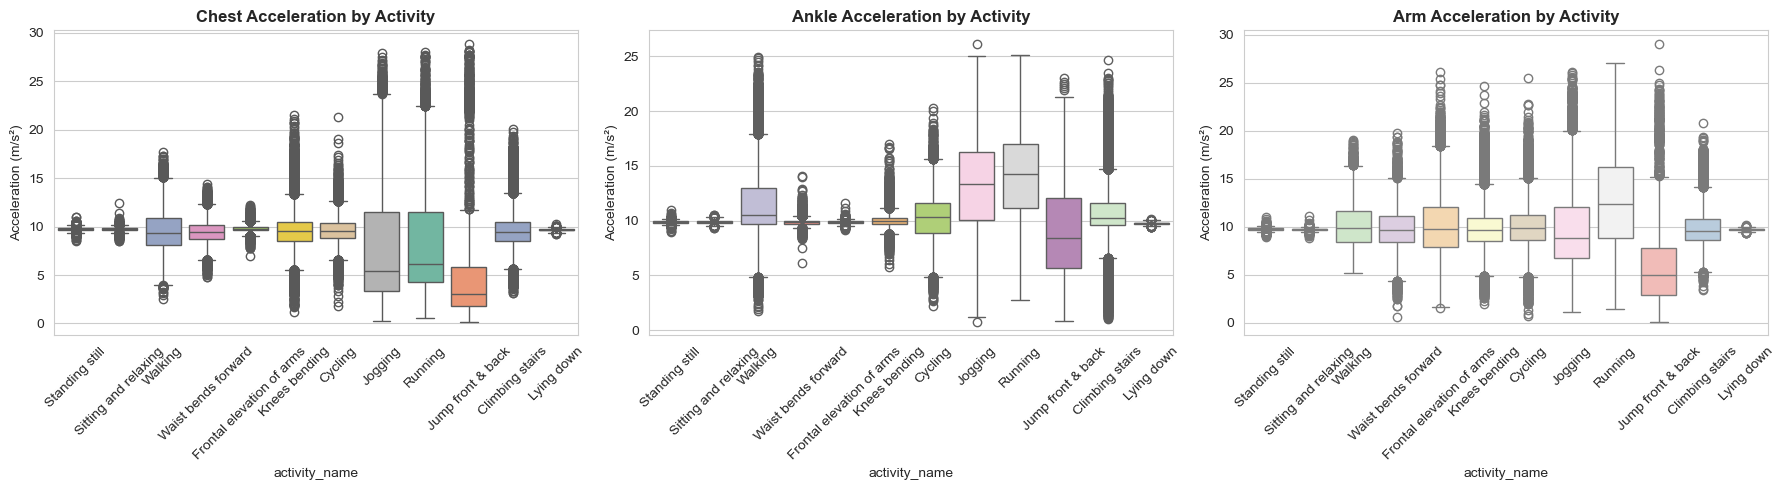

In [7]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for ax, col, palette, title in zip(axes, 
    ['chest_acc_magnitude', 'ankle_acc_magnitude', 'arm_acc_magnitude'],
    ['Set2', 'Set3', 'Pastel1'], ['Chest', 'Ankle', 'Arm']):
    sns.boxplot(data=data_clean, x='activity_name', y=col, palette=palette, ax=ax)
    ax.set_title(f'{title} Acceleration by Activity', fontweight='bold')
    ax.set_ylabel('Acceleration (m/s²)')
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

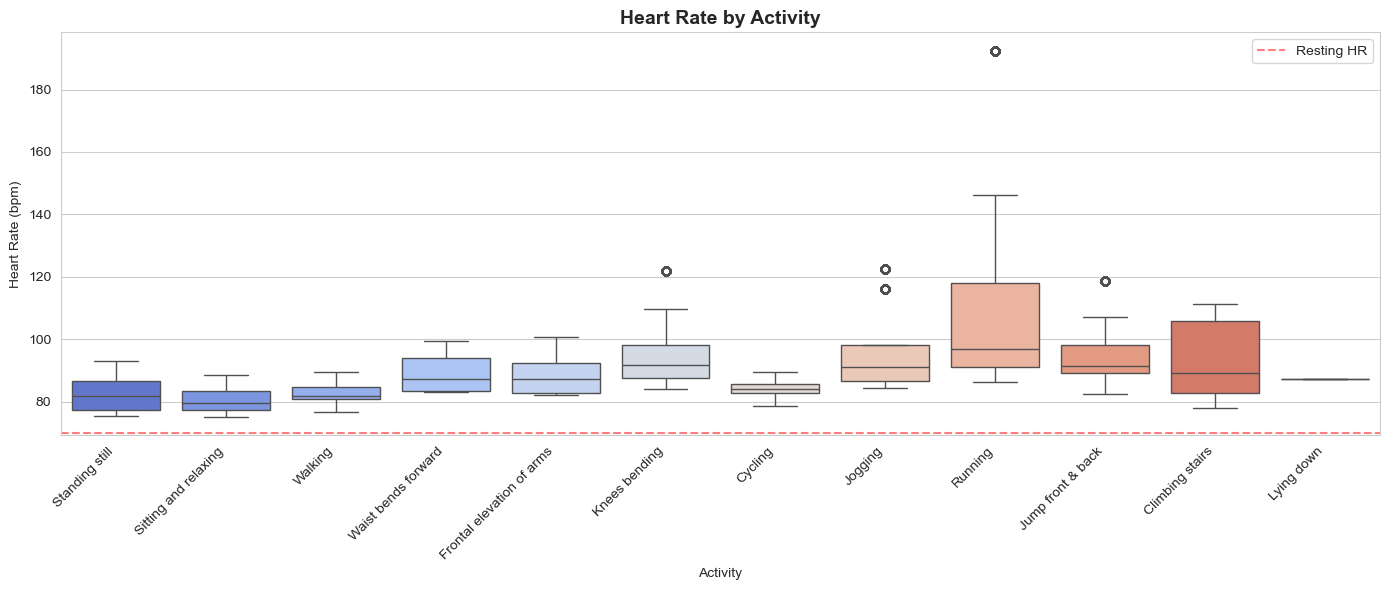

In [8]:
plt.figure(figsize=(14, 6))
sns.boxplot(data=data_clean, x='activity_name', y='heart_rate_estimate', palette='coolwarm')
plt.title('Heart Rate by Activity', fontsize=14, fontweight='bold')
plt.xlabel('Activity')
plt.ylabel('Heart Rate (bpm)')
plt.xticks(rotation=45, ha='right')
plt.axhline(y=70, color='red', linestyle='--', alpha=0.5, label='Resting HR')
plt.legend()
plt.tight_layout()
plt.show()



Correlation Analysis:



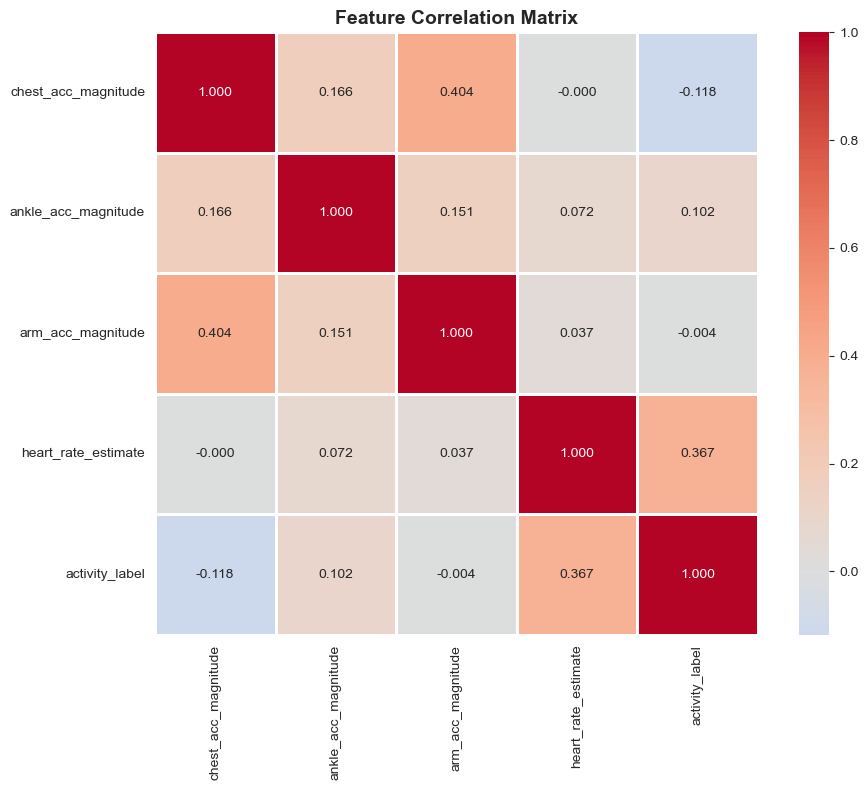

                     chest_acc_magnitude  ankle_acc_magnitude  \
chest_acc_magnitude             1.000000             0.165851   
ankle_acc_magnitude             0.165851             1.000000   
arm_acc_magnitude               0.403667             0.151373   
heart_rate_estimate            -0.000336             0.072454   
activity_label                 -0.118139             0.102374   

                     arm_acc_magnitude  heart_rate_estimate  activity_label  
chest_acc_magnitude           0.403667            -0.000336       -0.118139  
ankle_acc_magnitude           0.151373             0.072454        0.102374  
arm_acc_magnitude             1.000000             0.036884       -0.004316  
heart_rate_estimate           0.036884             1.000000        0.367005  
activity_label               -0.004316             0.367005        1.000000  


In [9]:
print("\n\nCorrelation Analysis:\n")

corr = data_clean[['chest_acc_magnitude', 'ankle_acc_magnitude', 'arm_acc_magnitude', 
                    'heart_rate_estimate', 'activity_label']].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', center=0, fmt='.3f', square=True, linewidths=1)
plt.title('Feature Correlation Matrix', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()
print(corr)

In [10]:
print("\n\nHypothesis Testing Setup:\n")

test_activities = ['Walking', 'Jogging', 'Running', 'Sitting and relaxing', 'Standing still', 'Cycling']
data_test = data_clean[data_clean['activity_name'].isin(test_activities)]

print(f"Selected activities: {test_activities}")
print(f"Total samples: {len(data_test):,}\n")
print(data_test['activity_name'].value_counts())



Hypothesis Testing Setup:

Selected activities: ['Walking', 'Jogging', 'Running', 'Sitting and relaxing', 'Standing still', 'Cycling']
Total samples: 126,549

activity_name
Standing still          30720
Sitting and relaxing    30720
Cycling                 30657
Walking                 23934
Jogging                  7685
Running                  2833
Name: count, dtype: int64


In [11]:
print("\n\nIndependent T-Test: High vs Low Intensity\n")

high_int = data_test[data_test['activity_name'].isin(['Jogging', 'Running'])]
low_int = data_test[data_test['activity_name'].isin(['Sitting and relaxing', 'Standing still'])]

print(f"High intensity (n={len(high_int):,}): Jogging, Running")
print(f"Low intensity (n={len(low_int):,}): Sitting and relaxing, Standing still\n")

# Chest acceleration
t_stat_c, p_val_c = ttest_ind(high_int['chest_acc_magnitude'], low_int['chest_acc_magnitude'])
h_mean_c, l_mean_c = high_int['chest_acc_magnitude'].mean(), low_int['chest_acc_magnitude'].mean()
h_std_c, l_std_c = high_int['chest_acc_magnitude'].std(), low_int['chest_acc_magnitude'].std()

print("Chest Acceleration:")
print(f"  High: {h_mean_c:.3f} ± {h_std_c:.3f} m/s²")
print(f"  Low:  {l_mean_c:.3f} ± {l_std_c:.3f} m/s²")
print(f"  t = {t_stat_c:.4f}, p = {p_val_c:.6f} ({'SIGNIFICANT' if p_val_c<0.05 else 'NOT SIGNIFICANT'})")

pooled_c = np.sqrt(((len(high_int)-1)*h_std_c**2 + (len(low_int)-1)*l_std_c**2) / (len(high_int)+len(low_int)-2))
cohens_c = (h_mean_c - l_mean_c) / pooled_c
print(f"  Cohen's d = {cohens_c:.3f} ({'Large' if abs(cohens_c)>=0.5 else 'Medium' if abs(cohens_c)>=0.2 else 'Small'} effect)")

# Heart rate
t_stat_h, p_val_h = ttest_ind(high_int['heart_rate_estimate'], low_int['heart_rate_estimate'])
h_mean_h, l_mean_h = high_int['heart_rate_estimate'].mean(), low_int['heart_rate_estimate'].mean()
h_std_h, l_std_h = high_int['heart_rate_estimate'].std(), low_int['heart_rate_estimate'].std()

print("\nHeart Rate:")
print(f"  High: {h_mean_h:.1f} ± {h_std_h:.1f} bpm")
print(f"  Low:  {l_mean_h:.1f} ± {l_std_h:.1f} bpm")
print(f"  t = {t_stat_h:.4f}, p = {p_val_h:.6f} ({'SIGNIFICANT' if p_val_h<0.05 else 'NOT SIGNIFICANT'})")

pooled_h = np.sqrt(((len(high_int)-1)*h_std_h**2 + (len(low_int)-1)*l_std_h**2) / (len(high_int)+len(low_int)-2))
cohens_h = (h_mean_h - l_mean_h) / pooled_h
print(f"  Cohen's d = {cohens_h:.3f} ({'Large' if abs(cohens_h)>=0.5 else 'Medium' if abs(cohens_h)>=0.2 else 'Small'} effect)")



Independent T-Test: High vs Low Intensity

High intensity (n=10,518): Jogging, Running
Low intensity (n=61,440): Sitting and relaxing, Standing still

Chest Acceleration:
  High: 8.556 ± 7.008 m/s²
  Low:  9.757 ± 0.168 m/s²
  t = -42.4104, p = 0.000000 (SIGNIFICANT)
  Cohen's d = -0.448 (Medium effect)

Heart Rate:
  High: 97.7 ± 17.7 bpm
  Low:  81.5 ± 5.1 bpm
  t = 186.6737, p = 0.000000 (SIGNIFICANT)
  Cohen's d = 1.970 (Large effect)


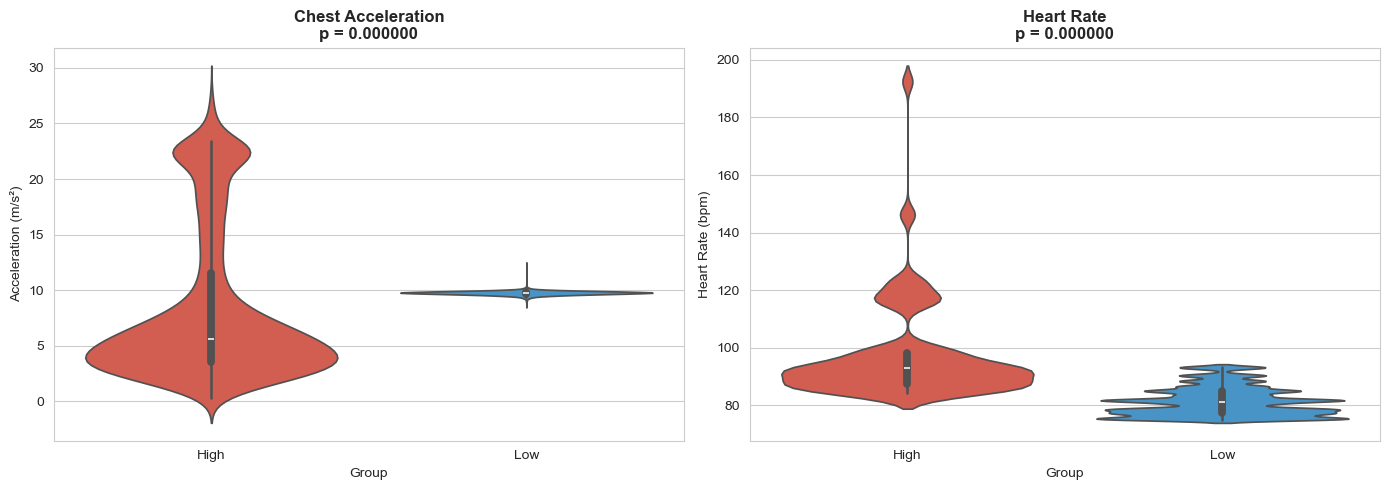

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

combined_c = pd.concat([high_int[['chest_acc_magnitude']].assign(Group='High'),
                        low_int[['chest_acc_magnitude']].assign(Group='Low')])
sns.violinplot(data=combined_c, x='Group', y='chest_acc_magnitude', palette=['#e74c3c', '#3498db'], ax=axes[0])
axes[0].set_title(f'Chest Acceleration\np = {p_val_c:.6f}', fontweight='bold')
axes[0].set_ylabel('Acceleration (m/s²)')

combined_h = pd.concat([high_int[['heart_rate_estimate']].assign(Group='High'),
                        low_int[['heart_rate_estimate']].assign(Group='Low')])
sns.violinplot(data=combined_h, x='Group', y='heart_rate_estimate', palette=['#e74c3c', '#3498db'], ax=axes[1])
axes[1].set_title(f'Heart Rate\np = {p_val_h:.6f}', fontweight='bold')
axes[1].set_ylabel('Heart Rate (bpm)')

plt.tight_layout()
plt.show()

In [13]:
print("\n\nOne-Way ANOVA: Multiple Activities\n")

anova_activities = ['Walking', 'Jogging', 'Running', 'Sitting and relaxing', 'Cycling']
anova_data = data_test[data_test['activity_name'].isin(anova_activities)]

print(f"Comparing: {anova_activities}\n")

# Chest acceleration
groups_c = [g['chest_acc_magnitude'].values for _, g in anova_data.groupby('activity_name')]
f_c, p_c = f_oneway(*groups_c)

print("Chest Acceleration:")
print(f"  F = {f_c:.4f}, p = {p_c:.8f} ({'SIGNIFICANT' if p_c<0.05 else 'NOT SIGNIFICANT'})")
print("  Means by activity:")
for act in anova_activities:
    m = anova_data[anova_data['activity_name']==act]['chest_acc_magnitude'].mean()
    s = anova_data[anova_data['activity_name']==act]['chest_acc_magnitude'].std()
    print(f"    {act}: {m:.3f} ± {s:.3f} m/s²")

# Heart rate
groups_h = [g['heart_rate_estimate'].values for _, g in anova_data.groupby('activity_name')]
f_h, p_h = f_oneway(*groups_h)

print("\nHeart Rate:")
print(f"  F = {f_h:.4f}, p = {p_h:.8f} ({'SIGNIFICANT' if p_h<0.05 else 'NOT SIGNIFICANT'})")
print("  Means by activity:")
for act in anova_activities:
    m = anova_data[anova_data['activity_name']==act]['heart_rate_estimate'].mean()
    s = anova_data[anova_data['activity_name']==act]['heart_rate_estimate'].std()
    print(f"    {act}: {m:.1f} ± {s:.1f} bpm")



One-Way ANOVA: Multiple Activities

Comparing: ['Walking', 'Jogging', 'Running', 'Sitting and relaxing', 'Cycling']

Chest Acceleration:
  F = 479.4757, p = 0.00000000 (SIGNIFICANT)
  Means by activity:
    Walking: 9.604 ± 2.160 m/s²
    Jogging: 8.305 ± 6.942 m/s²
    Running: 9.235 ± 7.142 m/s²
    Sitting and relaxing: 9.749 ± 0.178 m/s²
    Cycling: 9.600 ± 1.257 m/s²

Heart Rate:
  F = 15599.5486, p = 0.00000000 (SIGNIFICANT)
  Means by activity:
    Walking: 82.7 ± 3.9 bpm
    Jogging: 94.6 ± 11.4 bpm
    Running: 106.2 ± 26.7 bpm
    Sitting and relaxing: 80.4 ± 4.1 bpm
    Cycling: 84.3 ± 2.9 bpm


In [14]:
if p_c < 0.05:
    print("\n\nPost-hoc Pairwise Comparisons (Chest Acceleration):\n")
    
    pairs = list(combinations(anova_activities, 2))
    bonf_alpha = 0.05 / len(pairs)
    print(f"Bonferroni-corrected alpha = {bonf_alpha:.6f}\n")
    
    results = []
    for a1, a2 in pairs:
        g1 = anova_data[anova_data['activity_name']==a1]['chest_acc_magnitude']
        g2 = anova_data[anova_data['activity_name']==a2]['chest_acc_magnitude']
        _, p = ttest_ind(g1, g2)
        sig = 'Sig (Bonf)' if p<bonf_alpha else 'Sig' if p<0.05 else 'NS'
        print(f"  {a1} vs {a2}: p = {p:.6f} ({sig})")
        results.append({'Comparison': f"{a1} vs {a2}", 'p_value': p, 'Significance': sig})
    
    pd.DataFrame(results).to_csv('pairwise_comparisons.csv', index=False)
    print("\nSaved to: pairwise_comparisons.csv")



Post-hoc Pairwise Comparisons (Chest Acceleration):

Bonferroni-corrected alpha = 0.005000

  Walking vs Jogging: p = 0.000000 (Sig (Bonf))
  Walking vs Running: p = 0.000000 (Sig (Bonf))
  Walking vs Sitting and relaxing: p = 0.000000 (Sig (Bonf))
  Walking vs Cycling: p = 0.791952 (NS)
  Jogging vs Running: p = 0.000000 (Sig (Bonf))
  Jogging vs Sitting and relaxing: p = 0.000000 (Sig (Bonf))
  Jogging vs Cycling: p = 0.000000 (Sig (Bonf))
  Running vs Sitting and relaxing: p = 0.000000 (Sig (Bonf))
  Running vs Cycling: p = 0.000000 (Sig (Bonf))
  Sitting and relaxing vs Cycling: p = 0.000000 (Sig (Bonf))

Saved to: pairwise_comparisons.csv


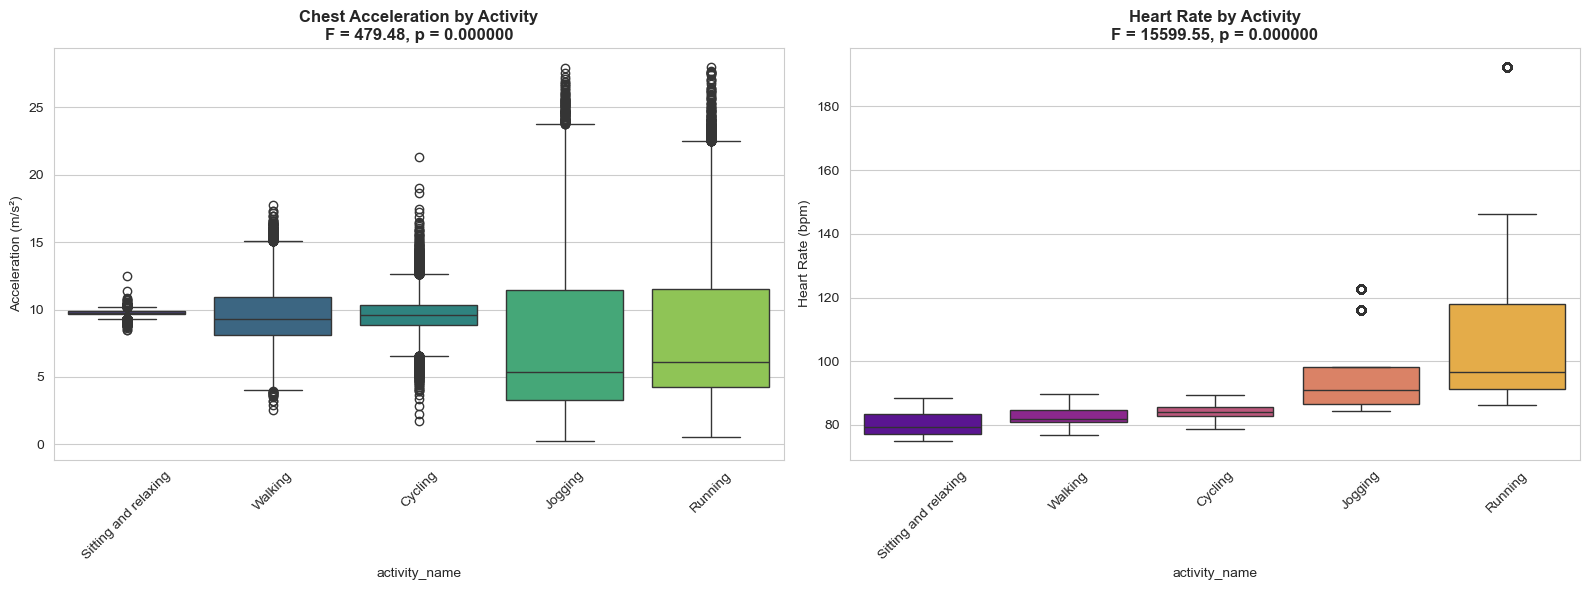

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.boxplot(data=anova_data, x='activity_name', y='chest_acc_magnitude', palette='viridis', ax=axes[0])
axes[0].set_title(f'Chest Acceleration by Activity\nF = {f_c:.2f}, p = {p_c:.6f}', fontweight='bold')
axes[0].set_ylabel('Acceleration (m/s²)')
axes[0].tick_params(axis='x', rotation=45)

sns.boxplot(data=anova_data, x='activity_name', y='heart_rate_estimate', palette='plasma', ax=axes[1])
axes[1].set_title(f'Heart Rate by Activity\nF = {f_h:.2f}, p = {p_h:.6f}', fontweight='bold')
axes[1].set_ylabel('Heart Rate (bpm)')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()



Inter-Subject Variation:



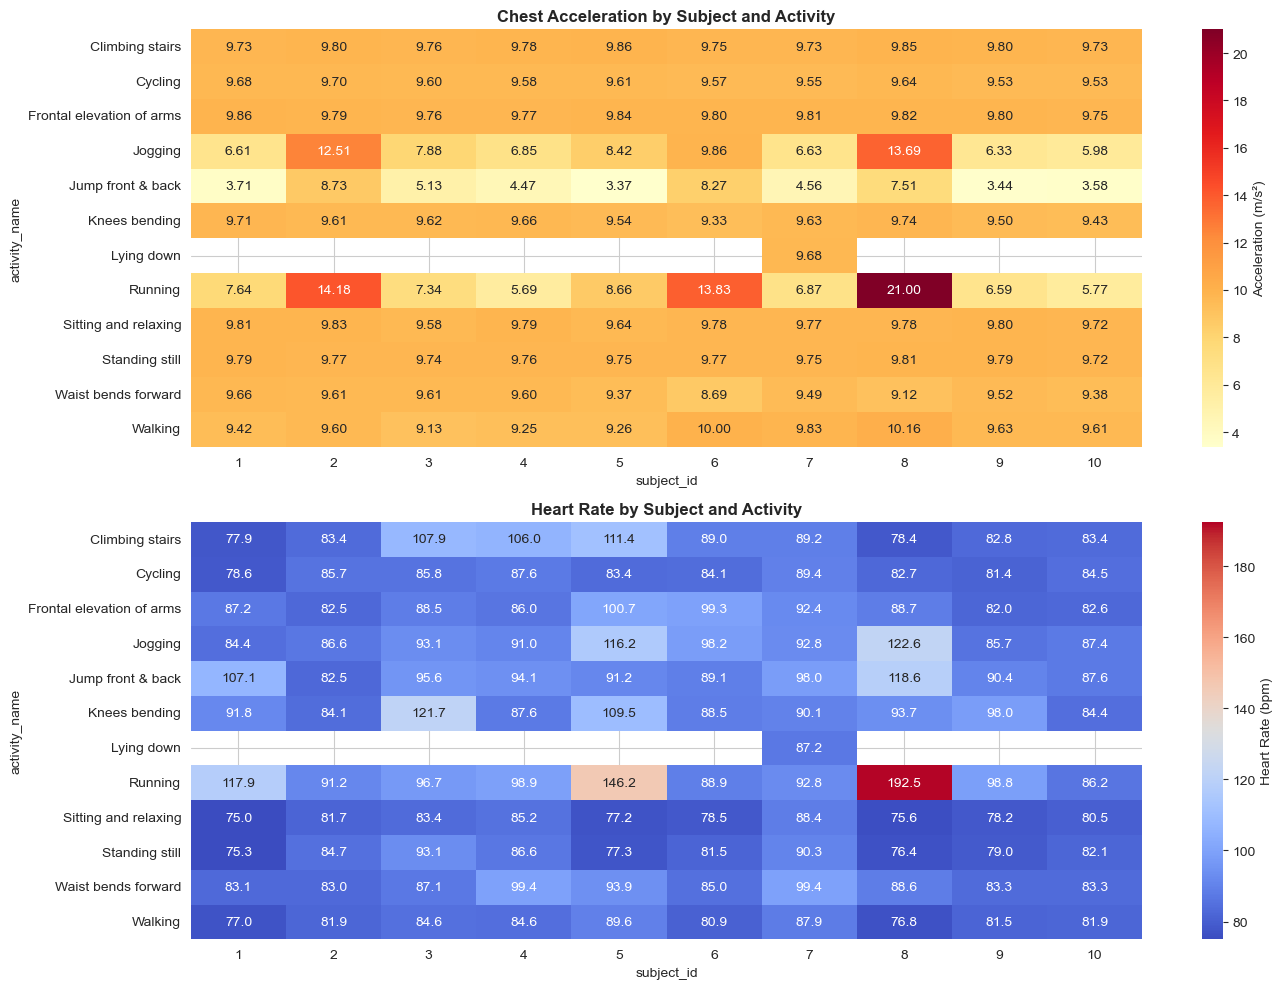

Coefficient of Variation by Activity:
activity_name
Climbing stairs               21.46
Cycling                       13.10
Frontal elevation of arms      3.33
Jogging                       83.58
Jump front & back            115.14
Knees bending                 21.00
Lying down                     1.21
Running                       77.34
Sitting and relaxing           1.83
Standing still                 1.60
Waist bends forward           12.50
Walking                       22.49
Name: chest_acc_magnitude, dtype: float64


Analysis Complete


In [16]:
print("\n\nInter-Subject Variation:\n")

subj_means = data_clean.groupby(['subject_id', 'activity_name']).agg({
    'chest_acc_magnitude': 'mean', 'heart_rate_estimate': 'mean'
}).reset_index()

fig, axes = plt.subplots(2, 1, figsize=(14, 10))

pivot_c = subj_means.pivot(index='activity_name', columns='subject_id', values='chest_acc_magnitude')
sns.heatmap(pivot_c, annot=True, fmt='.2f', cmap='YlOrRd', cbar_kws={'label': 'Acceleration (m/s²)'}, ax=axes[0])
axes[0].set_title('Chest Acceleration by Subject and Activity', fontweight='bold')

pivot_h = subj_means.pivot(index='activity_name', columns='subject_id', values='heart_rate_estimate')
sns.heatmap(pivot_h, annot=True, fmt='.1f', cmap='coolwarm', cbar_kws={'label': 'Heart Rate (bpm)'}, ax=axes[1])
axes[1].set_title('Heart Rate by Subject and Activity', fontweight='bold')

plt.tight_layout()
plt.show()

print("Coefficient of Variation by Activity:")
cv = data_clean.groupby('activity_name')['chest_acc_magnitude'].apply(lambda x: (x.std()/x.mean())*100).round(2)
print(cv)

print("\n\nAnalysis Complete")